# **<font color='red'>Introduction and Initial Data Exploration</font>**

### **Project background and objectives**

### **Dataset overview and descriptive statistics**

To begin with, we will import all the libraries we will use in this project, as well as our dataset.

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor



df = pd.read_csv('autos.csv')

### General overview of the dataset

We start with df.head() to quickly see the first few rows of our DataFrame so we can confirm the column names, data types, and sample values before diving deeper.

In [95]:
df.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,...,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,...,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,...,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,...,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,...,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [96]:
df.shape

(371528, 21)

We have a dataset containing 21 columns describing more than 370,000 used car listings. These columns include information on the vehicle specifications, equipment, mileage, age, fuel type, location, and other relevant characteristics.
The goal is to predict the **price** of a used car based on these features.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   index                371528 non-null  int64 
 1   dateCrawled          371528 non-null  object
 2   name                 371528 non-null  object
 3   seller               371528 non-null  object
 4   offerType            371528 non-null  object
 5   price                371528 non-null  int64 
 6   abtest               371528 non-null  object
 7   vehicleType          333659 non-null  object
 8   yearOfRegistration   371528 non-null  int64 
 9   gearbox              351319 non-null  object
 10  powerPS              371528 non-null  int64 
 11  model                351044 non-null  object
 12  kilometer            371528 non-null  int64 
 13  monthOfRegistration  371528 non-null  int64 
 14  fuelType             338142 non-null  object
 15  brand                371528 non-nu

In [98]:
df.describe()

,index,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,371528.000000,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,185763.500000,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,107251.039743,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,92881.750000,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,185763.500000,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,278645.250000,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,371527.000000,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


We call df.describe() to get quick summary stats (count, mean, std, quartiles) for our numeric columns, for example checking a price column’s min/median/max helps us spot outliers before deeper analysis.



### Motivation for data cleaning

Using the first checks (`df.head()`, `df.info()`, `df.describe()`), we see 371,528 rows across 21 columns with many holes (e.g., `vehicleType` missing in ~37k rows and `notRepairedDamage` missing in ~72k), and several clearly inconsistent values: prices range from 0 to 2,147,484,000 while the median is only 2,950; registration years run from 1000 to 9999; `powerPS` goes from 0 to 20,000; mileage is capped at 150,000 km with a 5,000 km floor; `nrOfPictures` is stuck at 0.
These concrete issues point to outliers and entry errors that would distort the distributions and any model we train.

Therefore, before proceeding with deeper analysis or modeling, we now move on to the data cleaning phase, in which we will correct impossible values, handle missing data, detect and treat outliers, and prepare the dataset for further processing.


# **<font color='red'>Data Cleaning</font>**

### **Handling missing values**

In [100]:
missing_values = df.isnull().sum().to_frame('Missing_values')
missing_values['Percentage_missing_values'] = ((missing_values['Missing_values']/df.shape[0])*100)

missing_values.style\
    .format({'Percentage_missing_values': '{:.2f}%'} )\
    .background_gradient(cmap='Reds')\
    .set_properties(**{'text-align': 'center'})

,Missing_values,Percentage_missing_values
index,0,0.00%
dateCrawled,0,0.00%
name,0,0.00%
seller,0,0.00%
offerType,0,0.00%
price,0,0.00%
abtest,0,0.00%
vehicleType,37869,10.19%
yearOfRegistration,0,0.00%
gearbox,20209,5.44%


Our initial idea was to delete all rows from the dataset containing at least one missing value. However, we realized that there are too many rows concerned, so this solution is no longer feasible because it would completely skew our predictions. We will therefore analyze and process the columns on a case-by-case basis:

In [101]:
missing_cols = df.columns[df.isnull().any()]

df[missing_cols].dtypes

vehicleType          object
gearbox              object
model                object
fuelType             object
notRepairedDamage    object
dtype: object

Since all of our missing columns are 'objects', we are going to work on those **objective categorical features** of our dataset:  
`vehicleType`, `gearbox`, `model`, `fuelType`, and `notRepairedDamage`.

These columns represent well-defined, factual properties of a car (type, model, fuel, gearbox, repair status), not subjective opinions or free text. Because of that, it is reasonable to try to infer missing values from **similar cars** in the dataset.

Our strategy is:

1. **Create missing-value indicators**  
   For each categorical feature with missing values, we add a companion column (e.g. `model_was_missing`) that records whether the original value was missing. This lets downstream models know that the information was absent in the raw data.

2. **Similarity-based imputation**  
   For `vehicleType`, `gearbox`, `model`, and `fuelType`, we look for other rows that describe similar cars (same brand, powerPS, yearOfRegistration, and other relevant characteristics).  
   If we find enough similar cars, we impute the most frequent category among them.

3. **Explicit “Unknown” categories as fallback**  
   When we cannot confidently infer a value (not enough similar examples), we do **not** guess. Instead, we assign an explicit category such as `Unknown_model` or `Unknown_fuelType`, making the uncertainty transparent.

4. **Special case: `notRepairedDamage`**  
   For `notRepairedDamage`, missing values are replaced by the category `unknown`, indicating that the repair status of the vehicle is not known.

This approach keeps the data usable for modeling while limiting bias and avoiding fabricated information.


In [102]:
def impute_by_similarity(df, target_col, keys, min_matches=3):
    df = df.copy()
    missing_mask = df[target_col].isna()
    n_missing = missing_mask.sum()

    if n_missing == 0:
        return df, 0

    df_missing = df.loc[missing_mask, keys].copy()
    df_missing["_row_id"] = df_missing.index
    df_known = df.loc[~missing_mask, keys + [target_col]].copy()

    merged = df_missing.merge(
        df_known,
        on=keys,
        how="left",
        suffixes=("", "_y")
    )

    merged = merged.dropna(subset=[target_col])
    if merged.empty:
        return df, 0

    grouped = merged.groupby("_row_id")[target_col]
    counts = grouped.size()
    modes = grouped.agg(lambda s: s.mode().iloc[0])

    valid_idx = counts[counts >= min_matches].index
    if len(valid_idx) == 0:
        return df, 0

    mode_per_row = modes.loc[valid_idx]
    df.loc[mode_per_row.index, target_col] = mode_per_row

    n_imputed = len(mode_per_row)
    return df, n_imputed


def process_data(df):
    df = df.copy()

    cat_cols_to_impute = ["vehicleType", "gearbox", "model", "fuelType"]
    repair_col = "notRepairedDamage"

    for col in cat_cols_to_impute + [repair_col]:
        df[f"{col}_was_missing"] = df[col].isna()

    similarity_keys = {
        "model":       ["brand", "vehicleType", "fuelType", "gearbox", "powerPS", "yearOfRegistration"],
        "fuelType":    ["brand", "vehicleType", "gearbox", "model", "powerPS", "yearOfRegistration"],
        "gearbox":     ["brand", "vehicleType", "fuelType", "model", "powerPS", "yearOfRegistration"],
        "vehicleType": ["brand", "fuelType", "gearbox", "model", "powerPS", "yearOfRegistration"],
    }

    initial_missing = df[cat_cols_to_impute].isna().sum()
    similarity_counts = {}
    remaining_after_similarity = {}

    print("\n" + "=" * 32)
    print("Missing value imputation summary")
    print("=" * 32)

    for col in cat_cols_to_impute:
        df, n_imp = impute_by_similarity(df, col, similarity_keys[col], min_matches=3)
        similarity_counts[col] = n_imp
        remaining_after_similarity[col] = df[col].isna().sum()

    print("\nPer-column counts (similarity vs unknown):")
    for col in cat_cols_to_impute:
        init = int(initial_missing[col])
        sim = int(similarity_counts.get(col, 0))
        unk = int(remaining_after_similarity[col])
        print(f"- {col}: {sim} imputed by similarity, {unk} imputed as Unknown_{col} (initial missing: {init})")

    for col in cat_cols_to_impute:
        remaining = df[col].isna().sum()
        if remaining > 0:
            unknown_label = f"Unknown_{col}"
            df[col] = df[col].fillna(unknown_label)

    if repair_col in df.columns:
        n_before = df[repair_col].isna().sum()
        df[repair_col] = df[repair_col].fillna("unknown")
        n_after = df[repair_col].isna().sum()
        print(f"\n{repair_col}: {n_before} values imputed as 'unknown' (remaining NaN: {n_after})")

    print("\nFinal check (remaining missing values):")
    final_missing = df[cat_cols_to_impute + [repair_col]].isna().sum()
    print(final_missing.to_string())

    print("\n" + "=" * 20)
    print("Imputation completed")
    print("=" * 20 + "\n")

    return df

df = process_data(df)



Missing value imputation summary

Per-column counts (similarity vs unknown):
- vehicleType: 4767 imputed by similarity, 33102 imputed as Unknown_vehicleType (initial missing: 37869)
- gearbox: 8396 imputed by similarity, 11813 imputed as Unknown_gearbox (initial missing: 20209)
- model: 9098 imputed by similarity, 11386 imputed as Unknown_model (initial missing: 20484)
- fuelType: 15634 imputed by similarity, 17752 imputed as Unknown_fuelType (initial missing: 33386)

notRepairedDamage: 72060 values imputed as 'unknown' (remaining NaN: 0)

Final check (remaining missing values):
vehicleType          0
gearbox              0
model                0
fuelType             0
notRepairedDamage    0

Imputation completed



### **Correcting impossible or inconsistent entries**

In [103]:
def show_basic_stats(df):
    numeric_cols = ["yearOfRegistration", "price", "powerPS", "kilometer"]
    cat_cols = ["seller", "offerType"]

    print("\n" + "=" * 24)
    print("Basic numeric statistics")
    print("=" * 24)
    for col in numeric_cols:
        if col in df.columns:
            stats = df[col].describe()
            print(f"\n{col}")
            print("-" * len(col))
            print(
                stats[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
                .to_frame()
                .T
                .round(2)
                .to_string(index=False)
            )

    print("\n" + "=" * 60)
    print("Basic categorical distributions")
    print("=" * 60)
    for col in cat_cols:
        if col in df.columns:
            print(f"\n{col}")
            print("-" * len(col))
            print(df[col].value_counts(dropna=False))
    print("\n")

show_basic_stats(df)


Basic numeric statistics

yearOfRegistration
------------------
   count    mean   std    min    25%    50%    75%    max
371528.0 2004.58 92.87 1000.0 1999.0 2003.0 2008.0 9999.0

price
-----
   count     mean        std  min    25%    50%    75%          max
371528.0 17295.14 3587953.74  0.0 1150.0 2950.0 7200.0 2147483647.0

powerPS
-------
   count   mean    std  min  25%   50%   75%     max
371528.0 115.55 192.14  0.0 70.0 105.0 150.0 20000.0

kilometer
---------
   count      mean      std    min      25%      50%      75%      max
371528.0 125618.69 40112.34 5000.0 125000.0 150000.0 150000.0 150000.0

Basic categorical distributions

seller
------
seller
privat        371525
gewerblich         3
Name: count, dtype: int64

offerType
---------
offerType
Angebot    371516
Gesuch         12
Name: count, dtype: int64




We remove rows with physically impossible or inconsistent values (invalid registration dates, prices, power, mileage) and drop records with unexpected `seller` or `offerType` categories. This ensures the model is trained only on realistic car listings.

Before defining these rules, we first inspect the raw distributions of key numeric and categorical features using `.describe()` and `value_counts()`. This allows us to see clearly invalid ranges (e.g. `yearOfRegistration` equal to 1000 or 9999, `price` equal to 0 or in the billions, `powerPS` equal to 0 or 20,000) and to identify rare or unexpected categories in `seller` and `offerType`. Based on these summaries, we can justify our cleaning thresholds (valid year interval, strictly positive prices and power, realistic mileage, allowed categories) rather than choosing them arbitrarily.

In [104]:
def clean_impossible_entries(df):
    df_clean = df.copy()
    n_before = len(df_clean)

    mask_year = df_clean["yearOfRegistration"].between(1950, 2016)
    mask_month = df_clean["monthOfRegistration"].between(1, 12)
    mask_price = df_clean["price"] > 0
    mask_power = df_clean["powerPS"] > 0
    mask_offer = df_clean["offerType"] == "Angebot"

    mask = mask_year & mask_month & mask_price & mask_power & mask_offer
    df_clean = df_clean[mask].reset_index(drop=True)

    n_after = len(df_clean)
    print("=== Cleaning impossible or inconsistent entries ===")
    print(f"Rows before cleaning: {n_before}")
    print(f"Rows after cleaning:  {n_after}")
    print(f"Rows removed:         {n_before - n_after}")

    return df_clean

df = clean_impossible_entries(df)

=== Cleaning impossible or inconsistent entries ===
Rows before cleaning: 371528
Rows after cleaning:  295100
Rows removed:         76428


### **Treating extreme outliers**

After removing impossible values, we still need to handle extremely unusual but technically possible observations that can distort the model. We focus on `price` and `powerPS`, and remove extreme outliers using a combination of domain-informed bounds and an IQR-based rule. Concretely, we keep only cars with prices and power within a reasonable range around the interquartile interval, which helps stabilize the distributions and prevents a few extreme listings from dominating the training process.







In [105]:
def treat_extreme_outliers(df):
    df_clean = df.copy()
    n_before = len(df_clean)

    q1_price = df_clean["price"].quantile(0.25)
    q3_price = df_clean["price"].quantile(0.75)
    iqr_price = q3_price - q1_price
    lower_price = max(500, q1_price - 1.5 * iqr_price)
    upper_price = min(150000, q3_price + 1.5 * iqr_price)
    df_clean = df_clean[df_clean["price"].between(lower_price, upper_price)]

    q1_power = df_clean["powerPS"].quantile(0.25)
    q3_power = df_clean["powerPS"].quantile(0.75)
    iqr_power = q3_power - q1_power
    lower_power = max(40, q1_power - 1.5 * iqr_power)
    upper_power = min(300, q3_power + 1.5 * iqr_power)
    df_clean = df_clean[df_clean["powerPS"].between(lower_power, upper_power)]

    n_after = len(df_clean)
    print("=== Treating extreme outliers ===")
    print(f"Rows before cleaning:        {n_before}")
    print(f"Rows after cleaning:         {n_after}")
    print(f"Rows removed as outliers:    {n_before - n_after}")
    # print(f"Price kept in range:         [{lower_price:.0f}, {upper_price:.0f}]")
    # print(f"powerPS kept in range:       [{lower_power:.0f}, {upper_power:.0f}]")

    return df_clean

df = treat_extreme_outliers(df)

=== Treating extreme outliers ===
Rows before cleaning:        295100
Rows after cleaning:         255084
Rows removed as outliers:    40016


### **Fixing data types and formatting** 

In this step, we ensure that every column in the dataset has the appropriate data type before modeling. Object columns containing dates are converted to real datetime formats, categorical columns (such as brand, model, fuel type, or gearbox) are cast to `category`, and numerical fields (such as price, power, mileage, and registration year) are converted to integer types. This improves memory usage, speeds up computation, and prevents models from misinterpreting numeric or date values as plain text.

In [106]:
def fix_dtypes(df):
    df = df.copy()

    date_cols = ["dateCrawled", "dateCreated", "lastSeen"]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")

    cat_cols = [
        "name", "seller", "offerType", "abtest", "vehicleType",
        "gearbox", "model", "fuelType", "brand", "notRepairedDamage"
    ]
    for col in cat_cols:
        df[col] = df[col].astype("category")

    int_cols = [
        "yearOfRegistration", "monthOfRegistration", "powerPS",
        "kilometer", "price", "postalCode", "nrOfPictures"
    ]
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    return df
    
df = fix_dtypes(df)

### **Removing duplicates or corrupted records**

To avoid training the model on the same car multiple times, we first remove strict duplicate rows (identical values across all columns except the technical index). We then remove near-duplicate listings that clearly describe the same car (same name, seller, specifications, and location), keeping only the earliest occurrence. This reduces data redundancy, prevents certain cars from being over-represented, and helps eliminate corrupted or repeated records while preserving genuinely distinct vehicles.







In [114]:
def remove_duplicates(df, remove_near_duplicates=True):
    df_clean = df.copy()

    if "index" in df_clean.columns:
        id_col = "index"
    else:
        id_col = None

    n_before = len(df_clean)

    if id_col is not None:
        strict_cols = [c for c in df_clean.columns if c != id_col]
        df_clean = df_clean.drop_duplicates(subset=strict_cols, keep="first")
    else:
        df_clean = df_clean.drop_duplicates(keep="first")

    n_after_strict = len(df_clean)
    print("=== Removing strict duplicates ===")
    print(f"Rows before: {n_before}")
    print(f"Rows after:  {n_after_strict}")
    print(f"Rows removed as strict duplicates: {n_before - n_after_strict}")

    if remove_near_duplicates:
        sig_cols = [
            "name",
            "seller",
            "brand",
            "model",
            "yearOfRegistration",
            "monthOfRegistration",
            "gearbox",
            "fuelType",
            "vehicleType",
            "powerPS",
            "kilometer",
            "postalCode",
        ]
        sig_cols = [c for c in sig_cols if c in df_clean.columns]

        n_before_sig = len(df_clean)
        if "dateCreated" in df_clean.columns:
            df_clean = df_clean.sort_values("dateCreated")
        df_clean = df_clean.drop_duplicates(subset=sig_cols, keep="first")
        n_after_sig = len(df_clean)

        print("\n=== Removing near-duplicate listings ===")
        print(f"Rows before: {n_before_sig}")
        print(f"Rows after:  {n_after_sig}")
        print(f"Rows removed as near-duplicates: {n_before_sig - n_after_sig}")

    return df_clean
    
df = remove_duplicates(df, remove_near_duplicates=True)

=== Removing strict duplicates ===
Rows before: 246077
Rows after:  246077
Rows removed as strict duplicates: 0

=== Removing near-duplicate listings ===
Rows before: 246077
Rows after:  246077
Rows removed as near-duplicates: 0


We reduced the dataset from **371 528 rows** to **246 077 rows** through progressive cleaning steps.  
After removing impossible entries, treating outliers, imputing missing values, fixing data types, and eliminating duplicate listings, the dataset is now consistent, reliable, and ready for exploratory data analysis and visualization.


# **<font color='red'>Exploratory Data Analysis</font>**

In [93]:

# Configuration du style des graphiques
plt.style.use('seaborn-v0_8')  # Style moderne de seaborn
sns.set_theme(style="whitegrid")  # Style de grille pour seaborn
plt.rcParams['figure.figsize'] = (15, 10)

# 1. Distribution des prix
plt.figure(figsize=(12, 6))
sns.histplot(df_train['price'], bins=50, kde=True)
plt.title('Distribution des prix des véhicules')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.yscale('log')
plt.show()

# 2. Boîtes à moustaches par type de véhicule
plt.figure(figsize=(14, 8))
sns.boxplot(x='vehicleType', y='price', data=df_train)
plt.title('Distribution des prix par type de véhicule')
plt.xticks(rotation=45)
plt.ylim(0, df_train['price'].quantile(0.95))
plt.tight_layout()
plt.show()

# 3. Matrice de corrélation
plt.figure(figsize=(12, 8))
corr = df_train.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()

# 4. Relation entre année d'immatriculation et prix
plt.figure(figsize=(12, 6))
sns.regplot(x='yearOfRegistration', y='price', data=df_train, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relation entre année d\'immatriculation et prix')
plt.tight_layout()
plt.show()

# 5. Distribution des kilomètres
plt.figure(figsize=(12, 6))
sns.histplot(df_train['kilometer'], bins=30, kde=True)
plt.title('Distribution des kilométrages')
plt.xlabel('Kilométrage')
plt.ylabel('Nombre de véhicules')
plt.tight_layout()
plt.show()

# 6. Prix moyen par type de carburant
plt.figure(figsize=(12, 6))
sns.barplot(x='fuelType', y='price', data=df_train, 
           estimator=np.median, errorbar=None)
plt.title('Prix médian par type de carburant')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Relation entre la puissance et le prix
plt.figure(figsize=(12, 6))
sns.scatterplot(x='powerPS', y='price', data=df_train, alpha=0.3)
plt.title('Relation entre la puissance (PS) et le prix')
plt.xlim(0, df_train['powerPS'].quantile(0.99))
plt.ylim(0, df_train['price'].quantile(0.99))
plt.tight_layout()
plt.show()

NameError: name 'df_train' is not defined

<Figure size 1200x600 with 0 Axes>

# **<font color='red'>Feature selection / suppression</font>**

In [8]:
cols_to_drop = [
        'index',
        'name',
        'dateCrawled',
        'dateCreated',
        'lastSeen',
        'seller',
        'offerType',
        'nrOfPictures'
    ]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# **<font color='red'>Feature engineering</font>**

In [6]:
def features(df):
    df = df.copy()

    # -------------------------------
    # 1) Label Encoding pour catégorielles
    # -------------------------------
    cat_cols = [
        'abtest',
        'vehicleType',
        'gearbox',
        'model',
        'fuelType',
        'brand',
        'notRepairedDamage'
    ]

    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

    # -------------------------------
    # 2) Features dérivées automobiles
    # -------------------------------

    # Âge du véhicule
    df["car_age"] = 2025 - df["yearOfRegistration"]

    # Km par an (plus important que le km brut)
    df["km_per_year"] = df["kilometer"] / (df["car_age"] + 1)

    # Indique si la voiture a été immatriculée en début d’année
    df["early_registration"] = df["monthOfRegistration"].apply(lambda x: 1 if x <= 6 else 0)

    # Puissance relative par kilométrage (proxy de l’état)
    df["ps_per_1000km"] = df["powerPS"] / (df["kilometer"] / 1000 + 1)

    # -------------------------------
    # 3) Interactions utiles
    # -------------------------------

    # Puissance par âge
    df["ps_per_year"] = df["powerPS"] / (df["car_age"] + 1)

    # Kilométrage ajusté par âge
    df["normalized_km"] = df["kilometer"] / df["car_age"].replace(0, 1)

    # -------------------------------
    # 4) Nettoyage final
    # -------------------------------
    # Rien à supprimer ici, toutes les features sont utiles
    # Mais si tu veux enlever l'année : je peux le faire

    return df

df_train = features(df_train)

NameError: name 'df_train' is not defined

# **<font color='red'>Modelisation</font>**

In [62]:
X = df_train.drop(columns=["price"])
y = df_train["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [63]:
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [None, 20]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
rf_best_model = grid_rf.best_estimator_
rf_best_pred = rf_best_model.predict(X_test)
rf_best_r2 = r2_score(y_test, rf_best_pred)

print(f"Random Forest Best R²: {rf_best_r2:.4f}")

Random Forest Best R²: 0.8615


In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lr_pca_model = LinearRegression()
lr_pca_model.fit(X_train_pca, y_train)
lr_pca_pred = lr_pca_model.predict(X_test_pca)
lr_pca_r2 = r2_score(y_test, lr_pca_pred)
print(f"Linear Regression (PCA) R²: {lr_pca_r2:.4f}")


Linear Regression (PCA) R²: 0.4827


In [71]:
baseline_pred = np.full_like(y_test, y_train.mean())

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# poly_model.fit(X_train, y_train)
# poly_pred = poly_model.predict(X_test)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

In [72]:
models = {
    "Baseline": baseline_pred,
    "Linear Regression": lr_pred,
    # "Polynomial Regression": poly_pred,
    "Decision Tree": tree_pred,
    "Random Forest": rf_pred,
    "Gradient Boosting": gb_pred,
    "XGBoost": xgb_pred,
    "CatBoost": cat_pred
}

r2_scores = {model: r2_score(y_test, pred) for model, pred in models.items()}
mae_scores = {model: mean_absolute_error(y_test, pred) for model, pred in models.items()}
mse_scores = {model: mean_squared_error(y_test, pred) for model, pred in models.items()}
rmse_scores = {model: np.sqrt(mean_squared_error(y_test, pred)) for model, pred in models.items()}

df_r2 = pd.DataFrame.from_dict(r2_scores, orient='index', columns=["R2 Score"])
df_mae = pd.DataFrame.from_dict(mae_scores, orient='index', columns=["Mean Absolute Error"])
df_mse = pd.DataFrame.from_dict(mse_scores, orient='index', columns=["Mean Squared Error"])
df_rmse = pd.DataFrame.from_dict(rmse_scores, orient='index', columns=["Root Mean Squared Error"])

metrics_df = pd.concat([df_r2, df_mae, df_mse, df_rmse], axis=1)
display(metrics_df)

,R2 Score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
Baseline,-0.000014,3833.307654,2.281650e+07,4776.661753
Linear Regression,0.619064,2116.456032,8.691495e+06,2948.134126
Decision Tree,0.735185,1566.088492,6.042070e+06,2458.062184
Random Forest,0.861581,1148.995552,3.158203e+06,1777.133373
Gradient Boosting,0.830767,1328.230212,3.861262e+06,1965.009507
XGBoost,0.869836,1121.049438,2.969846e+06,1723.324259
CatBoost,0.874541,1104.124457,2.862491e+06,1691.889805


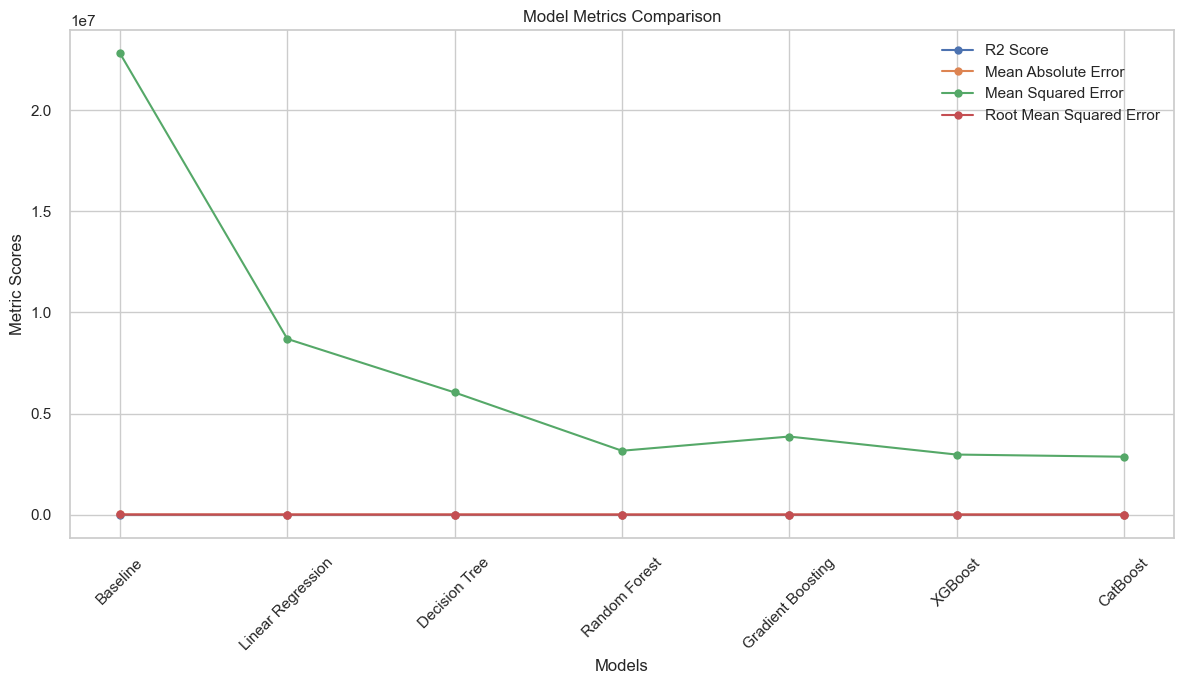

In [73]:
algorithms = list(models.keys())

plt.figure(figsize=(12, 7))

plt.plot(algorithms, df_r2.values, marker='o', label="R2 Score")
plt.plot(algorithms, df_mae.values, marker='o', label="Mean Absolute Error")
plt.plot(algorithms, df_mse.values, marker='o', label="Mean Squared Error")
plt.plot(algorithms, df_rmse.values, marker='o', label="Root Mean Squared Error")

plt.title("Model Metrics Comparison")
plt.xlabel("Models")
plt.ylabel("Metric Scores")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

c:\Users\hugod\anaconda3\envs\data_project\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 48648884.0000 - mae: 5355.0361 - val_loss: 41198024.0000 - val_mae: 5010.7271 - learning_rate: 0.0010
Epoch 2/100
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 31018306.0000 - mae: 4326.9199 - val_loss: 21326406.0000 - val_mae: 3686.7373 - learning_rate: 0.0010
Epoch 3/100
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 14517546.0000 - mae: 2913.7229 - val_loss: 8932362.0000 - val_mae: 2308.6611 - learning_rate: 0.0010
Epoch 4/100
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7092977.0000 - mae: 1923.7179 - val_loss: 4567244.5000 - val_mae: 1465.5950 - learning_rate: 0.0010
Epoch 5/100
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5434234.5000 - mae: 1604.1790 - val_loss: 4131798.2500 - val_mae: 1360.0713 - learning_rate: 0.0010
Epoch 6/100
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5195601.5000 - mae: 1579.2954 - val_loss: 4030872.5000 - val_mae: 1348.0138 - learning_rate: 0.0010
Epoch 7/100
1509/

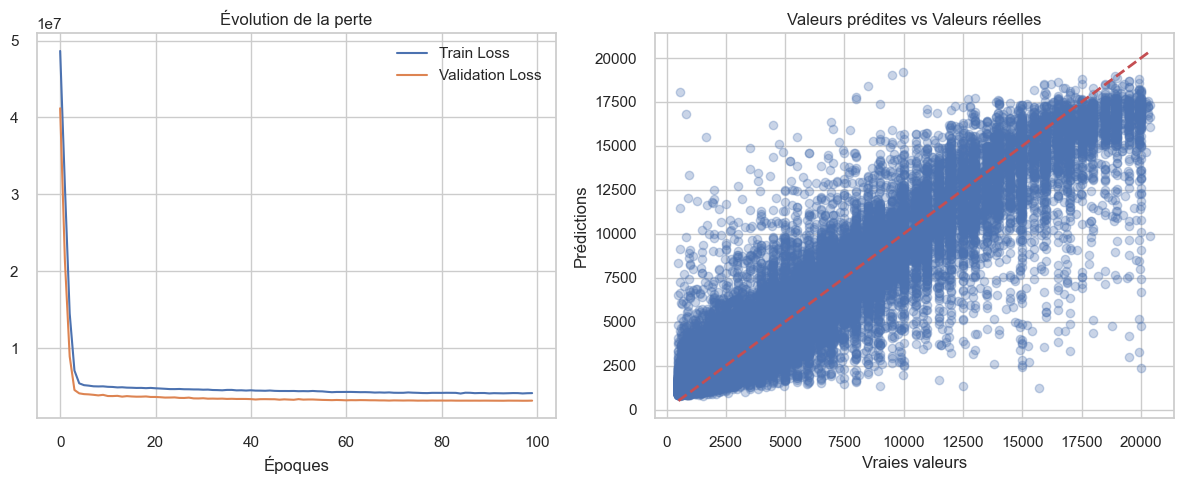

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Séparation des caractéristiques et de la cible
X = df_train.drop('price', axis=1)  # Supposons que 'price' est votre variable cible
y = df_train['price']

# 2. Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 3. Prétraitement
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# 4. Création du modèle
input_dim = X_train_processed.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(1)  # Couche de sortie pour la régression
])

# 5. Compilation
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6. Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# 7. Entraînement
history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# 8. Évaluation
y_pred = model.predict(X_test_processed).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')


# 9. Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Vraies valeurs')
plt.ylabel('Prédictions')
plt.title('Valeurs prédites vs Valeurs réelles')

plt.tight_layout()
plt.show()

In [79]:
from keras_tuner import Hyperband
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_model(hp):
    model = Sequential()
    
    # Hyperparamètres à optimiser
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_reg', 1e-6, 1e-2, sampling='log'))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Initialisation du tuner
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='tuner_results',
    project_name='car_price_prediction'
)

# Recherche des meilleurs hyperparamètres
tuner.search(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    epochs=100,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]
)

# Meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

Trial 33 Complete [00h 01m 46s]
val_loss: 4306004.0

Best val_loss So Far: 4161634.0
Total elapsed time: 02h 11m 29s

Search: Running Trial #34

Value             |Best Value So Far |Hyperparameter
6                 |3                 |num_layers
448               |416               |units_0
3.3878e-06        |1.1666e-06        |l2_reg
0.1               |0.3               |dropout
320               |512               |units_1
0.0010922         |0.0013565         |learning_rate
192               |480               |units_2
128               |384               |units_3
160               |64                |units_4
160               |64                |units_5
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
3018/3018 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 35712208.0000 - mae: 4554.4531 - val_loss: 13288219.0000 - v

KeyboardInterrupt: 